In [1]:
import cvxpy as cp
from cvxpygen import cpg
import numpy as np
import numba
import cffi
from numba.core.typing import cffi_utils
import matplotlib.pyplot as plt

In [3]:
class vonMises:
    def __init__(self, sig0):
        self.sig0 = sig0
    def criterion(self, sig):
        dev = np.array([[2/3., -1/3., -1/3., 0],
                        [-1/3., 2/3., -1/3., 0],
                        [-1/3., -1/3., 2/3., 0],
                        [0, 0, 0, 1]])
        s = dev @ sig
        return [np.sqrt(3/2)*cp.norm(s) <= self.sig0]

class Rankine:
    def __init__(self):
        self.fc = cp.Parameter()
        self.ft = cp.Parameter()
    def criterion(self, sig):
        Sig = cp.bmat([[sig[0], sig[3]/np.sqrt(2), 0],
                      [sig[3]/np.sqrt(2), sig[1], 0],
                      [0, 0, sig[2]]])
        return [cp.lambda_max(Sig) <= self.ft, cp.lambda_min(Sig) >= -self.fc]
    
class IsotropicElasticity:
    def __init__(self, E, nu):
        self.E = E
        self.nu = nu
        self.lmbda = E*nu/(1+nu)/(1-2*nu)
        self.mu = E/2/(1+nu)
    
    def C(self):
        l, m = self.lmbda, self.mu
        return np.array([[l+2*m, l, l, 0],
                        [l, l+2*m, l, 0],
                        [l, l, l+2*m, 0],
                        [0, 0, 0, 2*m]])

class Material:
    def __init__(self, elasticity, yield_criterion, plane_stress=False):
        self.C = elasticity.C()
        self.criterion = yield_criterion.criterion
        self.plane_stress = plane_stress
    
vM = vonMises(sig0=1)

Ra = Rankine()
Ra.fc.value = 200.
Ra.ft.value = 100.

mat = Material(IsotropicElasticity(1, 0.3), vM, plane_stress=False)
                        
class ReturnMapping:
    def __init__(self, mat, solver=cp.SCS):
        self.mat = mat
        self.deps = cp.Parameter((4,), name='deps')
        self.sig_old = cp.Parameter((4,), name='sig_old')
        self.sig_elas = self.sig_old + self.mat.C @ self.deps
    
        self.sig_old.value = np.zeros(((4,)))

        self.sig = cp.Variable((4, ), name='sig')
        obj = cp.quad_form(self.sig - self.sig_elas, np.linalg.inv(self.mat.C))
        
        self.cons = mat.criterion(self.sig)
        
        if self.mat.plane_stress:
            self.cons.append(self.sig[2] == 0)
        
        self.prob = cp.Problem(cp.Minimize(obj), self.cons)
        self.solver = solver
        
        print(self.prob.is_dcp(dpp=True))
        
    def solve(self, **kwargs):
        self.prob.solve(solver=self.solver, requires_grad=True, **kwargs)

        self.C_tang = np.zeros((4, 4))
        for i in range(4):
            z = np.zeros((4,))
            z[i] = 1
            self.deps.delta = z
            self.prob.derivative()
            self.C_tang[i, :] = self.sig.delta
    
rm = ReturnMapping(mat)

True


In [5]:
code_dir = 'code_dir'

In [6]:
cpg.generate_code(rm.prob, code_dir=code_dir, solver='SCS')

Generating code with CVXPYgen ...
CVXPYgen finished generating code.
Compiling python wrapper with CVXPYgen ... 
-- The C compiler identification is GNU 11.2.0
-- The CXX compiler identification is GNU 11.2.0
-- Detecting C compiler ABI info
-- Detecting C compiler ABI info - done
-- Check for working C compiler: /usr/bin/cc - skipped
-- Detecting C compile features
-- Detecting C compile features - done
-- Detecting CXX compiler ABI info
-- Detecting CXX compiler ABI info - done
-- Check for working CXX compiler: /usr/bin/c++ - skipped
-- Detecting CXX compile features
-- Detecting CXX compile features - done
-- Setting build type to 'Release' as none was specified.
-- Single precision floats (32bit) are OFF
-- Long integers (64bit) are OFF
-- COMPILER_OPTS = -DUSE_LAPACK -DCTRLC
-- Configuring done
-- Generating done
-- Build files have been written to: /mnt/work_folder/convex-plasticity/optimisation/code_dir/c/build
Scanning dependencies of target cpg
[  0%] Building C object CMakeF

/mnt/work_folder/convex-plasticity/optimisation/code_dir/c/solver_code/src/rw.c: In function ‘_scs_read_data’:
/mnt/work_folder/convex-plasticity/optimisation/code_dir/c/solver_code/src/rw.c:184:3: warning: ignoring return value of ‘fread’ declared with attribute ‘warn_unused_result’ [-Wunused-result]
  184 |   fread(&(file_int_sz), sizeof(uint32_t), 1, fin);
      |   ^~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
/mnt/work_folder/convex-plasticity/optimisation/code_dir/c/solver_code/src/rw.c:185:3: warning: ignoring return value of ‘fread’ declared with attribute ‘warn_unused_result’ [-Wunused-result]
  185 |   fread(&(file_float_sz), sizeof(uint32_t), 1, fin);
      |   ^~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
/mnt/work_folder/convex-plasticity/optimisation/code_dir/c/solver_code/src/rw.c:202:3: warning: ignoring return value of ‘fread’ declared with attribute ‘warn_unused_result’ [-Wunused-result]
  202 |   fread(&(file_version_sz), sizeof(uint32_t), 1, fin);
      |   ^~

[ 31%] Building C object CMakeFiles/cpg.dir/solver_code/src/scs_version.c.o
[ 34%] Building C object CMakeFiles/cpg.dir/solver_code/src/util.c.o
[ 37%] Building C object CMakeFiles/cpg.dir/solver_code/linsys/csparse.c.o
[ 41%] Building C object CMakeFiles/cpg.dir/solver_code/linsys/scs_matrix.c.o
[ 44%] Building C object CMakeFiles/cpg.dir/solver_code/linsys/cpu/direct/private.c.o
[ 48%] Building C object CMakeFiles/cpg.dir/solver_code/linsys/external/qdldl/qdldl.c.o
[ 51%] Building C object CMakeFiles/cpg.dir/solver_code/linsys/external/amd/SuiteSparse_config.c.o
[ 55%] Building C object CMakeFiles/cpg.dir/solver_code/linsys/external/amd/amd_1.c.o
[ 58%] Building C object CMakeFiles/cpg.dir/solver_code/linsys/external/amd/amd_2.c.o
[ 62%] Building C object CMakeFiles/cpg.dir/solver_code/linsys/external/amd/amd_aat.c.o
[ 65%] Building C object CMakeFiles/cpg.dir/solver_code/linsys/external/amd/amd_control.c.o
[ 68%] Building C object CMakeFiles/cpg.dir/solver_code/linsys/external/amd/a

In [7]:
# import extension module and register custom CVXPY solve method
from code_dir.cpg_solver import cpg_solve
rm.prob.register_solve('cpg', cpg_solve)

In [ ]:
N = 100
theta = np.linspace(0, 2*np.pi, N+1)
Eps = 0.1*np.vstack((np.cos(theta), np.sin(theta), 0*theta, 0*theta)).T
Sig = []

for i, t in enumerate(theta):
    rm.sig_old.value = np.zeros((4, ))
    rm.deps.value = Eps[i,:]
    rm.prob.solve(method='cpg', updated_params=['deps', 'sig_old'], verbose=True)
    Sig.append(rm.sig.value)
    #Eps.append(Eps[-1]+rm.deps.value)

Sig = np.asarray(Sig)
Eps = np.asarray(Eps)

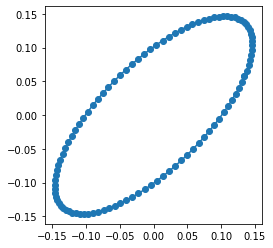

In [21]:
plt.plot(Sig[:, 0], Sig[:, 1], "-o")
plt.gca().set_aspect("equal")

In [21]:
# solve problem conventionally
val = rm.prob.solve(solver='SCS')
val

3.428569337364942e-18

In [10]:
# solve problem with C code via python wrapper
val = rm.prob.solve(method='cpg', updated_params=['deps', 'sig_old'], verbose=False)
val

1.9873365059487113e-05

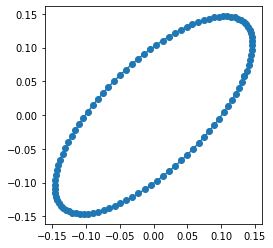

In [56]:
N = 100
theta = np.linspace(0, 2*np.pi, N+1)
Eps = 0.1*np.vstack((np.cos(theta), np.sin(theta), 0*theta, 0*theta)).T
Sig = []

for i, t in enumerate(theta):
    rm.sig_old.value = np.zeros((4, ))
    rm.deps.value = Eps[i,:]
    rm.solve()
    Sig.append(rm.sig.value)
    #Eps.append(Eps[-1]+rm.deps.value)

Sig = np.asarray(Sig)
Eps = np.asarray(Eps)

plt.plot(Sig[:, 0], Sig[:, 1], "-o")
plt.gca().set_aspect("equal")

In [12]:
with open('cffi_wrapper/cffi_wrapper.c', 'r') as file:
    cdef = file.read()

with open('cffi_wrapper/cffi_wrapper.h', 'r') as file:
    source = file.read()
    
lib_dir = os.path.join(os.getcwd(), code_dir + '/c/build/out')
solver_include_dir = os.path.join(os.getcwd(), code_dir + '/c/solver_code/include')
include_dir = os.path.join(os.getcwd(), code_dir + '/c/include')

ffibuilder = cffi.FFI()

ffibuilder.set_source(
  module_name='_cpglib', 
  source=source,
  include_dirs = [include_dir, solver_include_dir],
  libraries = ['cpg'],
  library_dirs = [lib_dir],
)

ffibuilder.cdef(csource=cdef)

ffibuilder.compile()

'/mnt/work_folder/convex-plasticity/optimisation/_cpglib.cpython-39-x86_64-linux-gnu.so'

In [13]:
import _cpglib

cffi_utils.register_module(_cpglib)

CPG_Updated_python_t = cffi_utils.map_type(_cpglib.ffi.typeof('CPG_Updated_cpp_t'), use_record_dtype=True)
CPG_Params_python_t = cffi_utils.map_type(_cpglib.ffi.typeof('CPG_Params_cpp_t'), use_record_dtype=True)
CPG_Result_python_t = cffi_utils.map_type(_cpglib.ffi.typeof('CPG_Result_cpp_t'), use_record_dtype=True)

cffi_utils.register_type(_cpglib.ffi.typeof('CPG_Updated_cpp_t'), CPG_Updated_python_t)
cffi_utils.register_type(_cpglib.ffi.typeof('CPG_Params_cpp_t'), CPG_Params_python_t)
cffi_utils.register_type(_cpglib.ffi.typeof('CPG_Result_cpp_t'), CPG_Result_python_t)

sig = cffi_utils.map_type(_cpglib.ffi.typeof(_cpglib.lib.solve_cpp), use_record_dtype=True)

In [14]:
@numba.cfunc(sig, nopython=True)
def solve_wrapper(upd, par, res):
    _cpglib.lib.solve_cpp(upd, par, res)

cpg_sol = solve_wrapper.ctypes

In [44]:
def my_cpg_solve(problem: cp.problems.problem.Problem, **kwargs):
    
    #Preliminary initialization of parameters, functions, etc (before the numba-function invocation)

    upd = _cpglib.ffi.new("CPG_Updated_cpp_t *", {})
    par = _cpglib.ffi.new("CPG_Params_cpp_t *", {})
    res = _cpglib.ffi.new("CPG_Result_cpp_t *", {})

    upd_numpy = np.ndarray(buffer=_cpglib.ffi.buffer(upd), dtype=numba.np.numpy_support.as_dtype(CPG_Updated_python_t), shape=1,)
    par_numpy = np.ndarray(buffer=_cpglib.ffi.buffer(par), dtype=numba.np.numpy_support.as_dtype(CPG_Params_python_t), shape=1,)
    res_numpy = np.ndarray(buffer=_cpglib.ffi.buffer(res), dtype=numba.np.numpy_support.as_dtype(CPG_Result_python_t), shape=1,)

    updated_params = ["sig_old", "deps"]
    for p in updated_params:
        setattr(upd, p, True)

    _cpglib.lib.cpg_set_solver_default_settings()

    for key, value in kwargs.items():
        try:
            eval(' _cpglib.lib.cpg_set_solver_%s(value)' % key)
        except AttributeError:
            raise(AttributeError('Solver setting "%s" not available.' % key))

    # set parameter values
    # sig_old_value = problem.param_dict['sig_old'].value.flatten(order='F')
    # deps_value = problem.param_dict['deps'].value.flatten(order='F')

    # par_numpy['sig_old'][:] = sig_old_value
    # par_numpy['deps'][:] = deps_value

    N = 100
    theta = np.linspace(0, 2*np.pi, N+1)
    Eps = 0.1*np.vstack((np.cos(theta), np.sin(theta), 0*theta, 0*theta)).T
    zeros = np.zeros((4, ))
    Sig = np.zeros_like(Eps)

    par_numpy['sig_old'][:] = zeros[:]
    par_numpy['deps'][:] = Eps[0,:]

    @numba.njit
    def call_solver(upd_numpy: np.ndarray, par_numpy: np.ndarray, res_numpy: np.ndarray, Sig):
        for i in range(N+1):
            par_numpy['sig_old'][:] = zeros[:]
            par_numpy['deps'][:] = Eps[i,:]

            cpg_sol(upd_numpy.ctypes.data, par_numpy.ctypes.data, res_numpy.ctypes.data)

            Sig[i,:] = res_numpy['prim']['sig'][0]

    call_solver(upd_numpy, par_numpy, res_numpy, Sig)
    Sig = np.asarray(Sig)
    Eps = np.asarray(Eps)

    return Sig, Eps

In [45]:
Sig, Eps = my_cpg_solve(rm.prob)

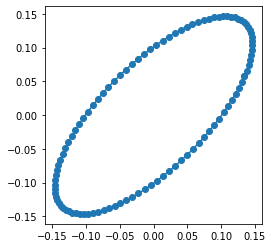

In [46]:
Sig, Eps = my_cpg_solve(rm.prob)
plt.plot(Sig[:, 0], Sig[:, 1], "-o")
plt.gca().set_aspect("equal")

In [ ]:
# Voight_indexes = np.zeros((3,3), dtype=np.uint8)
# Voight_indexes[0,0] = 0
# Voight_indexes[1,1] = 1
# Voight_indexes[2,2] = 2
# Voight_indexes[2,1] = 3
# Voight_indexes[1,2] = 3
# Voight_indexes[2,0] = 4
# Voight_indexes[0,2] = 4
# Voight_indexes[1,0] = 5
# Voight_indexes[0,1] = 5
# Voight_indexes

array([[0, 5, 4],
       [5, 1, 3],
       [4, 3, 2]], dtype=uint8)

In [ ]:
# def to_Voight_vector(sigma):
#     sigma_vec = np.zeros(6, dtype=PETSc.ScalarType)
#     for i in range(3):
#         for j in range(3):
#             sigma_vec[Voight_indexes[i,j]] = sigma[i,j]
#     return sigma_vec

# def to_Voight_matrix(C):
#     C_matrix = np.zeros((6, 6), dtype=PETSc.ScalarType)
    
#     for i in range(3):
#         for j in range(3):
#             for k in range(3):
#                 for l in range(3):
#                     C_matrix[Voight_indexes[i,j], Voight_indexes[k,l]] = C[i,j,k,l]

#     return C_matrix